In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! pip install dill

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import os
import numpy as np
from tensorflow.keras.regularizers import l2 , l1
from tensorflow.keras.applications import VGG16 , VGG19 , ResNet50 ,EfficientNetB0
import dill
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from transformers import ViTFeatureExtractor, ViTForImageClassification
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
data_dir = '/Data/Severity_Dataset'
img_height = 128
img_width = 128
batch_size = 32

In [10]:
class_names = os.listdir(data_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Data/Severity_Dataset'

In [ ]:
class_counts = {}

In [ ]:
# Count the number of images in each class directory
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):  # Check if it is a directory
        class_counts[class_name] = len(os.listdir(class_path))

In [ ]:
# Display the class counts
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

# Optionally, check for imbalance
total_images = sum(class_counts.values())
print(f"Total images: {total_images}")
for class_name, count in class_counts.items():
    print(f"Proportion of class '{class_name}': {count / total_images:.2%}")

Class 'Level 1': 194 images
Class 'Level 2': 193 images
Class 'Level 0': 198 images
Class 'Level 3': 194 images
Total images: 779
Proportion of class 'Level 1': 24.90%
Proportion of class 'Level 2': 24.78%
Proportion of class 'Level 0': 25.42%
Proportion of class 'Level 3': 24.90%


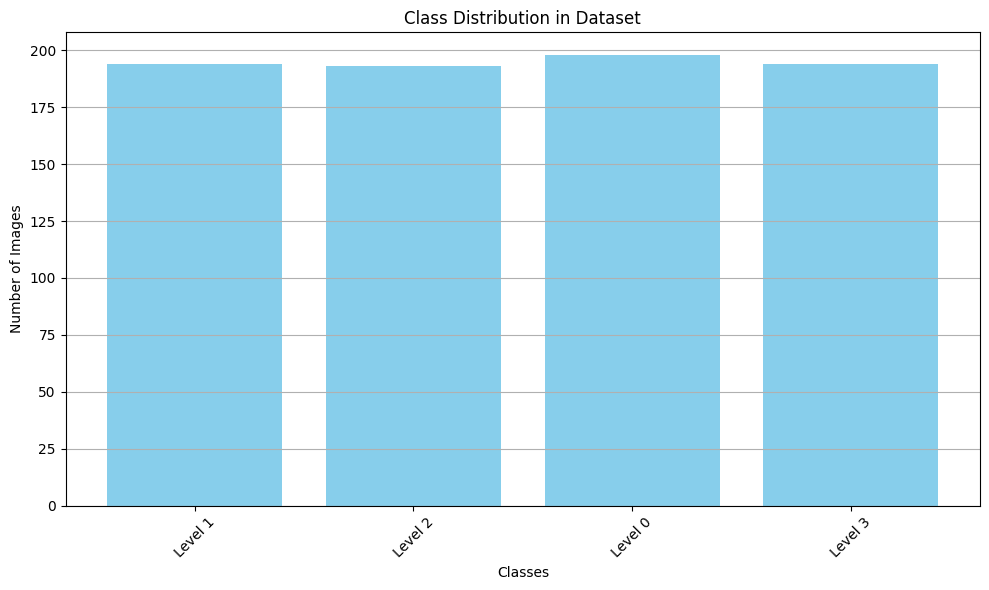

In [ ]:
# Plotting the class counts
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # Keep the validation split
    rotation_range=20,      # Add rotation
    width_shift_range=0.2,   # Add horizontal shift
    height_shift_range=0.2,  # Add vertical shift
    shear_range=0.2,        # Add shear transformation
    zoom_range=0.2,         # Add zoom
    horizontal_flip=True,    # Add horizontal flip
    fill_mode='nearest'     # How to fill newly created pixels
)

In [ ]:
train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 626 images belonging to 4 classes.


In [ ]:
train_ds.class_indices

{'Level 0': 0, 'Level 1': 1, 'Level 2': 2, 'Level 3': 3}

In [ ]:
val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 153 images belonging to 4 classes.


In [ ]:
val_ds.class_indices

{'Level 0': 0, 'Level 1': 1, 'Level 2': 2, 'Level 3': 3}

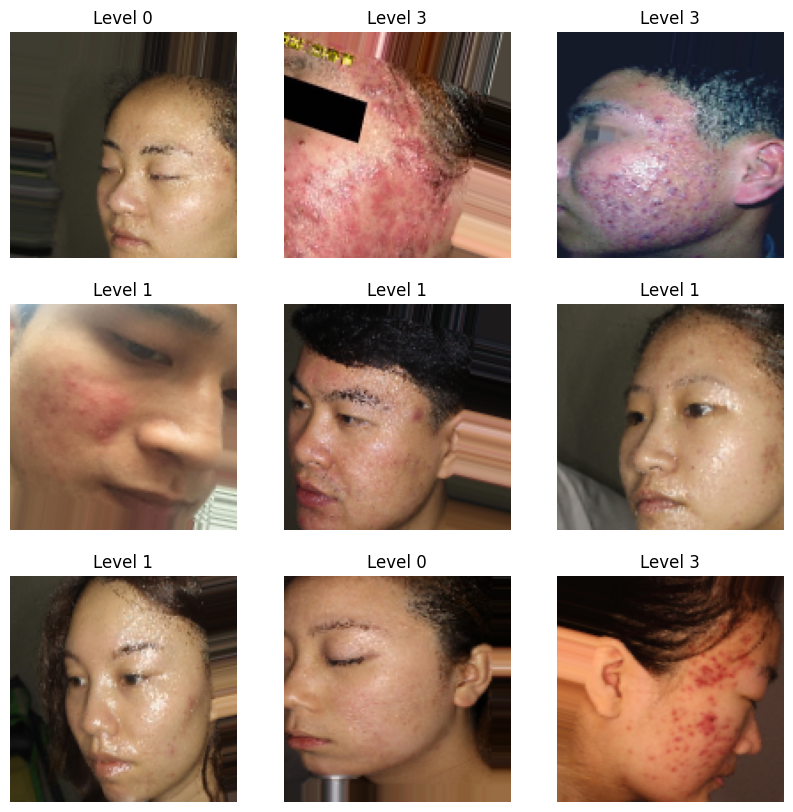

In [ ]:
class_names = train_ds.class_indices
plt.figure(figsize=(10, 10))

images, labels = next(train_ds)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(list(class_names.keys())[np.argmax(labels[i])])
    plt.axis("off")

plt.show()

In [ ]:
class_names

{'Level 0': 0, 'Level 1': 1, 'Level 2': 2, 'Level 3': 3}

In [ ]:
# data_augmentation = Sequential(
#   [
#     tf.keras.layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.2),
#   ]
# )

#CNN Model

In [ ]:
model_cnn = Sequential()

In [ ]:
model_cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   input_shape=[128, 128, 3],
                                   kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

model_cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l1(0.001)))
model_cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_cnn.add(tf.keras.layers.Dropout(0.25))

In [ ]:
model_cnn.add(tf.keras.layers.Flatten())

In [ ]:
model_cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))

In [ ]:
model_cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting

In [ ]:
model_cnn.add(tf.keras.layers.Dense(units=4, activation='softmax'))

In [ ]:
# Calculate class weights
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_ds.classes), y = train_ds.classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1500)                │       3,073,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           6,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,791,728 (29.72 MB)

 Trainable params: 7,791,728 (29.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 20
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights_dict
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 262s 10s/step - accuracy: 0.2191 - loss: 27.1710 - val_accuracy: 0.2549 - val_loss: 24.9087
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 152s 7s/step - accuracy: 0.2984 - loss: 24.1986 - val_accuracy: 0.2941 - val_loss: 22.0771
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.3035 - loss: 21.3911 - val_accuracy: 0.2484 - val_loss: 19.4382
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 254s 9s/step - accuracy: 0.2872 - loss: 18.7903 - val_accuracy: 0.2810 - val_loss: 16.9917
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.3117 - loss: 16.4178 - val_accuracy: 0.3987 - val_loss: 14.8152


In [ ]:
#recording history
with open('history_cnn_acne_severity.json', 'w') as f:
    json.dump(history_cnn.history, f)

In [ ]:
acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

In [ ]:
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

##DCNN

In [ ]:
# Load pre-trained ResNet50 model
base_model_dcnn = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

#  Fine-tune the later layers of the base model
for layer in base_model_dcnn.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Create DCNN model
model_dcnn = Sequential([
    base_model_dcnn,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])

In [ ]:
# Compile the DCNN model
model_dcnn.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the DCNN model
epochs = 20
history_dcnn = model_dcnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights_dict
)


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 298s 12s/step - accuracy: 0.3808 - loss: 1.5308 - val_accuracy: 0.2549 - val_loss: 1.7353
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 262s 12s/step - accuracy: 0.5376 - loss: 1.0250 - val_accuracy: 0.2484 - val_loss: 1.8666
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 259s 11s/step - accuracy: 0.7226 - loss: 0.6919 - val_accuracy: 0.2484 - val_loss: 5.8099
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 262s 11s/step - accuracy: 0.7642 - loss: 0.6112 - val_accuracy: 0.2484 - val_loss: 4.3990
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 234s 11s/step - accuracy: 0.7630 - loss: 0.5832 - val_accuracy: 0.2353 - val_loss: 1.9490


In [ ]:
#recording history
with open('history_dcnn_acne_severity.json', 'w') as f:
    json.dump(history_dcnn.history, f)

##ResNet

In [ ]:
def build_enhanced_resnet(input_shape, num_classes):
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_resnet.trainable = False  # Freeze the base model layers

    model = Sequential([
        base_model_resnet,
        Conv2D(512, (3, 3), activation='relu', padding='same'),  # Add a convolutional layer
        BatchNormalization(),                                  # Add Batch Normalization
        MaxPooling2D((2, 2)),                                 # Add Max Pooling
        Flatten(),
        Dense(256, activation='relu'),                         # Add a dense layer
        Dropout(0.5),                                          # Add Dropout for regularization
        Dense(num_classes, activation='softmax')              # Output layer
    ])

    return model

In [ ]:
# Build the enhanced ResNet model
model_resnet_enhanced = build_enhanced_resnet(input_shape=(img_height, img_width, 3), num_classes=4)


In [ ]:
model_resnet_enhanced.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_resnet_enhanced.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 512)           │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,553,028 (127.99 MB)

 Trainable params: 9,964,292 (38.01 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

In [ ]:
epochs_resnet_enhanced = 10
history_resnet_enhanced = model_resnet_enhanced.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_resnet_enhanced
)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.2264 - loss: 1.4250 - val_accuracy: 0.2418 - val_loss: 0.5693
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - accuracy: 0.2444 - loss: 0.6095 - val_accuracy: 0.2484 - val_loss: 0.5744
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.2780 - loss: 0.5918 - val_accuracy: 0.2484 - val_loss: 0.5720
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.2801 - loss: 0.5928 - val_accuracy: 0.2484 - val_loss: 0.5656
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.2915 - loss: 0.5865 - val_accuracy: 0.2484 - val_loss: 0.5689
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.2731 - loss: 0.5887 - val_accuracy: 0.2484 - val_loss: 0.5623
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.2907 - loss: 0.5817 - val_accuracy: 0.2484 - val_loss: 0.5624
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.2929 - loss: 0.5833 - val_accuracy: 0.2288 - v

In [ ]:
#Recording History
with open('history_resnet_enhanced.json', 'w') as f:
    json.dump(history_resnet_enhanced.history, f)

In [ ]:
# Choose the best model based on performance (e.g., validation accuracy)
best_model = model_cnn
if history_dcnn.history['val_accuracy'][-1] > history_cnn.history['val_accuracy'][-1]:
    best_model = model_dcnn
if history_resnet_enhanced.history['val_accuracy'][-1] > history_dcnn.history['val_accuracy'][-1] and history_resnet_enhanced.history['val_accuracy'][-1] > history_cnn.history['val_accuracy'][-1]:
    best_model = model_resnet_enhanced

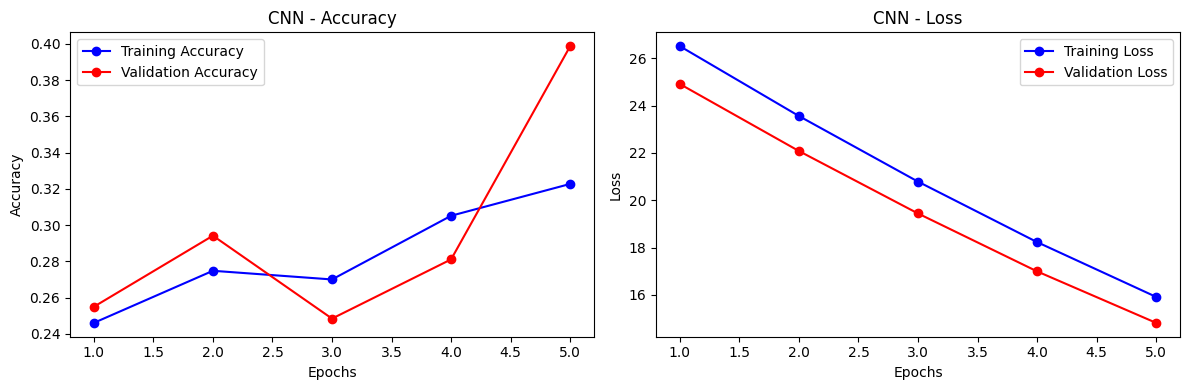

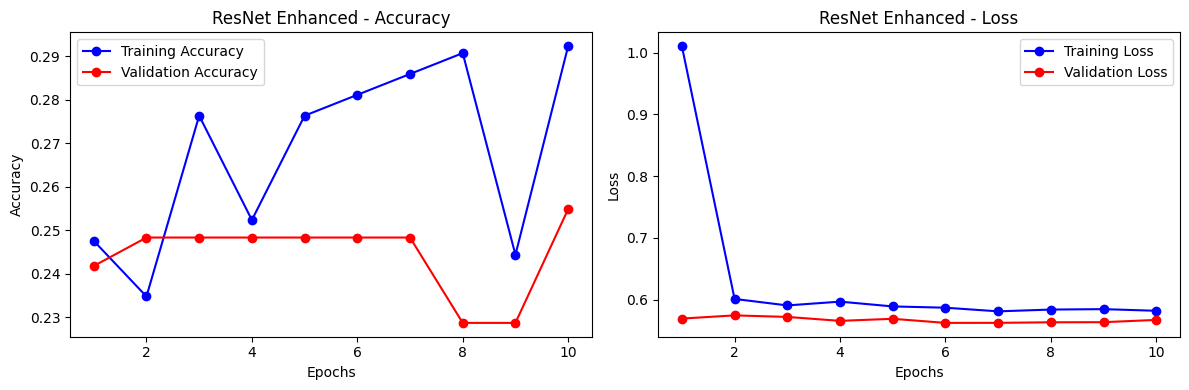

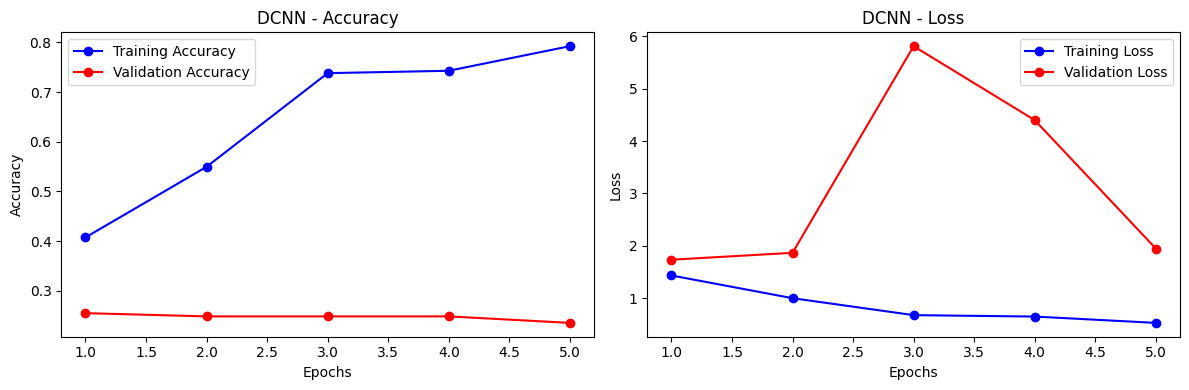

In [ ]:
def plot_accuracy_and_loss(history, model_name):
    """Plots the training and validation accuracy and loss curves."""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot accuracy and loss for each model
plot_accuracy_and_loss(history_cnn, "CNN")
plot_accuracy_and_loss(history_resnet_enhanced, "ResNet Enhanced")
plot_accuracy_and_loss(history_dcnn, "DCNN")

Shape of first_image: (128, 128, 3)
Data type of first_image: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


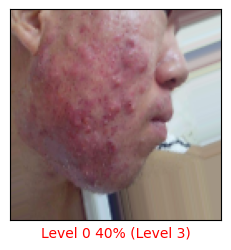

Actual label: Level 3
Predicted label: Level 0


In [ ]:
images_batch, labels_batch = next(val_ds)

first_image = images_batch[0]
first_label = labels_batch[0]  # This will be a one-hot encoded vector

print("Shape of first_image:", first_image.shape)
print("Data type of first_image:", first_image.dtype)

# Make prediction (ensure the input is in the correct format)
prediction = best_model.predict(np.expand_dims(first_image, axis=0))

# Get predicted class index
predicted_class_index = (prediction > 0.5).astype("int32")[0][0]  # Adjust for binary classification


# Get actual class index (since you're using multi-class classification with one-hot encoding)
actual_class_index = np.argmax(first_label)  # Get index of the maximum value (1 in this case)

# Function to plot image with prediction and true label
def plot_image(prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)  # No need for cmap=plt.cm.binary for color images

    predicted_label = (prediction > 0.5).astype("int32")[0][0]  # Adjust for binary classification
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    class_names_list = list(class_names.keys())  # Get class names

    plt.xlabel("{} {:2.0f}% ({})".format(class_names_list[predicted_label],
                                         100*np.max(prediction),
                                         class_names_list[true_label]),
               color=color)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(prediction, actual_class_index, first_image)
plt.show()

# Print actual and predicted labels
class_names_list = list(class_names.keys())  # Get class names
print("Actual label:", class_names_list[actual_class_index])
print("Predicted label:", class_names_list[predicted_class_index])

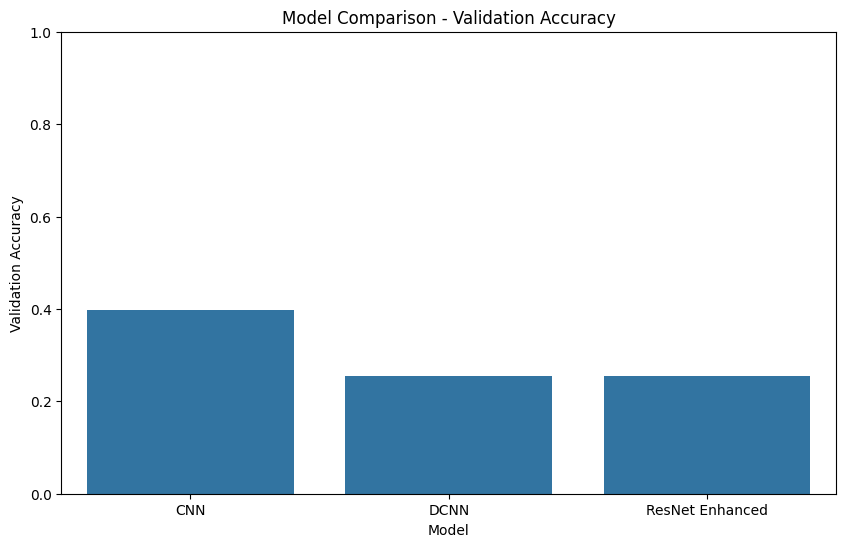

             Model  Validation Accuracy
0              CNN             0.398693
1             DCNN             0.254902
2  ResNet Enhanced             0.254902


In [ ]:
# Extract accuracy values from history objects
histories = [history_cnn, history_dcnn, history_resnet_enhanced]  # Update with your models
model_names = ["CNN", "DCNN", "ResNet Enhanced"]  # Update with your model names
val_accuracies = [max(history.history['val_accuracy']) for history in histories]

# Create a DataFrame
df = pd.DataFrame({"Model": model_names, "Validation Accuracy": val_accuracies})

# Sort the DataFrame by accuracy in descending order
df = df.sort_values(by="Validation Accuracy", ascending=False)

# Plot the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Validation Accuracy", data=df)
plt.title("Model Comparison - Validation Accuracy")
plt.xlabel("Model")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)  # Set y-axis limits for better visualization
plt.show()

# Print the sorted DataFrame
print(df)

In [ ]:
# 1. Predictions on the validation set
y_pred_prob = best_model.predict(val_ds)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


In [ ]:
# 2. True labels for the validation set
y_true = val_ds.classes  # Get the true class labels

In [ ]:
print(classification_report(y_true,y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00        77
     Level 1       0.46      1.00      0.63       123
     Level 2       0.00      0.00      0.00        38
     Level 3       0.00      0.00      0.00        29

    accuracy                           0.46       267
   macro avg       0.12      0.25      0.16       267
weighted avg       0.21      0.46      0.29       267



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cm = confusion_matrix(y_true, y_pred)

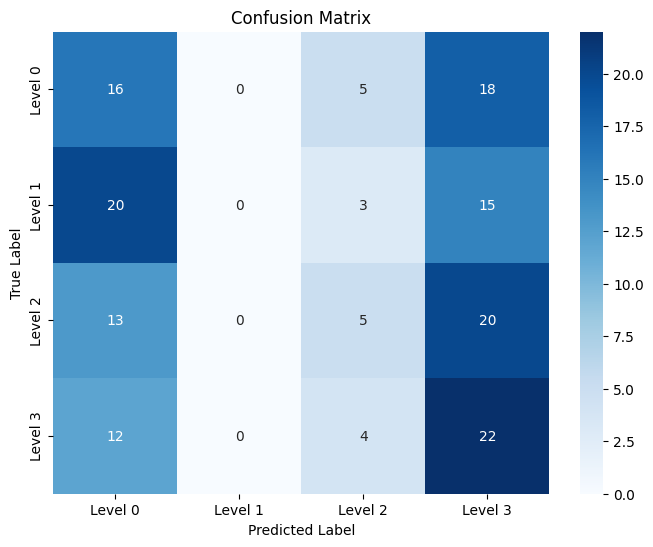

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# save the model using dill
with open('acne_severity_detection_model.pkl', 'wb') as f:
    dill.dump(model_cnn, f)

# Load the model using dill
with open('acne_severity_detection_model.pkl', 'rb') as f:
    model_cnn = dill.load(f)


In [ ]:
model_cnn.save('acne_severity_detection_model.h5')